# Otázky

1. když provedu `single_correction`, mám vrátit tu korekci a pak teprve
 updatovat hyperparametry? Dává to smysl, jinak by vyšlo několikrát to samé...

In [3]:
import numpy as np
import common
from exp_family import update_IW, init_IW_hyp, get_IW_pars_from_hyp
import exp_family
from typing import Tuple, Callable
from collections import defaultdict

In [4]:
Matrix = np.ndarray
MultiShape = np.ndarray
Scalar = np.number
Vector = np.ndarray

class IWPrior:
    hp: MultiShape = None
    p: Scalar = None
    
    def __init__(self, nu: Scalar, psi: Matrix):
        self.hp = np.array([
            -0.5 * psi, 
            -0.5 * (nu + psi.shape[0] + 1)
        ])
    
    @property
    def psi(self) -> Matrix:
        return -2 * self.hp[0]
    
    @property
    def nu(self) -> Scalar:
        return -2 * self.hp[1] - self.p - 1
    
    @property
    def p(self) -> int:
        return self.hp[0].shape[0]
    
    def expect(self):
        return self.psi / (self.nu - self.p - 1)
    
class MeasurementNode:
    P_prior: IWPrior = None
    R_prior: IWPrior = None
    F: Matrix = None
    Q: Matrix = None
    last_state: Vector = None
        
    logger = None
    
    def __init__(self,
                 x: Vector,
                 P_prior: IWPrior,
                 R_prior: IWPrior,
                 F: Matrix,
                 Q: Matrix,
                 H: Matrix,
                 rho: Scalar,
                 tau: Scalar,
                 observe: Callable,
                 N = 10,
                ):
        """
        Args:
            observe: a function without any arguments which
              performs a measurement by the node. In a dummy
              case, this is just an iterator of data faking
              measurements of the node.
        """
        self.last_state = x
        self.P_prior = P_prior
        self.R_prior = R_prior
        self.F = F
        self.Q = Q
        self.H = H
        self.rho = rho
        self.tau = tau
        self.observe = observe
        self.logger = defaultdict(list)
        
        self.P = self.P_prior.expect()
        
    def predict_state(self) -> Tuple[Vector, Matrix]:
        return common.time_update(self.last_state, self.P, self.F, self.Q)
    
    def _single_update(self, state_prediction, P_prediction, measurement,
                     init_hyp_P, init_hyp_R):
        x = state_prediction
        P = P_prediction
        for i in range(N):
            R, hyp_R = update_IW(init_hyp_R, 
                                 measurement, 
                                 self.H @ x, 
                                 self.H @ P @ self.H.T)
            P, hyp_P = update_IW(init_hyp_P, x, state_prediction, P)
            P, x = common.kalman_correction(H, P, R, state_prediction, measurement)
        return x, P, hyp_P, hyp_R
    
    def _init_hyp_P(self, P_predicted):
        init = exp_family.init_P_hyp(self.tau, P_predicted)
        return init
    
    
    def _init_hyp_R(self):
        init = exp_family.init_R_hyp(self.rho, self.R_prior.psi, self.R_prior.nu)
        return init
    
    
    def _single_kf(self, measurement):
        x_predicted, P_predicted = self.predict_state()
        init_hyp_P = self._init_hyp_P(P_predicted)
        init_hyp_R = self._init_hyp_R()
        return self._single_update(x_predicted, P_predicted, measurement,
                                  init_hyp_P, init_hyp_R)
    
    def single_kf(self, measurement):
        x, P, hyp_P, hyp_R = self._single_kf(measurement)
        self.last_state = x
        self.P = P
        self.P_prior.hp = hyp_P
        self.R_prior.hp = hyp_R
        self.log('x', x)
        self.log('P', x)
        return x, P, hyp_P, hyp_R
    
    def __call__(self):
        for measurement in self.observe():
            x, P, _, _ = self.single_kf(measurement)
    
    def log(self, key, val):
        self.logger[key].append(val)

In [5]:
def node_factory(x, P, u, U, F, Q, H, rho, tau, observe_func):
    P_p = IWPrior(P.shape[0] + tau + 1, tau * P)
    R_p = IWPrior(u, U)    
    return MeasurementNode(x, P_p, R_p, F, Q, H, rho, tau, observe_func)

In [6]:
def dummy_observe_func():
    return (y for y in traj.Y.T)

def dummy_observe_func_distorted():
    return (y for y in (traj.Y.T + np.random.normal(size=traj.Y.T.shape)*0.1))

In [7]:
traj, xk, P, tau, rho, u, U, H, F, Q, N = common.init_all()

In [8]:
m1 = node_factory(xk, P, u, U, F, Q, H, rho, tau, dummy_observe_func)
m2 = node_factory(xk, P, u, U, F, Q, H, rho, tau, dummy_observe_func_distorted)

# OK

In [7]:
m1()

In [8]:
x_log = np.array(m1.logger['x']).squeeze().T
# KF, just measurements
np.sqrt(((x_log[:2] - traj.X[:2]) ** 2 ).mean()), np.sqrt(((traj.Y[:2] - traj.X[:2]) ** 2 ).mean())

(0.4619606664283383, 0.7668096325216082)

# Distorted

In [9]:
m2()

In [10]:
x_log = np.array(m2.logger['x']).squeeze().T
# KF, just measurements
np.sqrt(((x_log[:2] - traj.X[:2]) ** 2 ).mean()), np.sqrt(((traj.Y[:2] - traj.X[:2]) ** 2 ).mean())

(0.4641385612967303, 0.7668096325216082)

# Multiple

In [ ]:
traj, xk, P, tau, rho, u, U, H, F, Q, N = common.init_all()
m1 = node_factory(xk, P, u, U, F, Q, H, rho, tau, dummy_observe_func)
m2 = node_factory(xk, P, u, U, F, Q, H, rho, tau, dummy_observe_func_distorted)

In [12]:
zs = traj.Y.T
zs_dist = traj.Y.T + np.random.normal(size=traj.Y.T.shape)*0.1

for z1, z2 in zip(zs, zs_dist):
    x1, P1, hyp_P1, hypR1 = m1.single_kf(z1)
    x2, P2, hyp_P2, hypR2 = m2.single_kf(z2)

In [13]:
x_log = ((np.array(m1.logger['x']) + np.array(m2.logger['x']))/2).squeeze().T
np.sqrt(((x_log[:2] - traj.X[:2]) ** 2 ).mean()), np.sqrt(((traj.Y[:2] - traj.X[:2]) ** 2 ).mean())

(0.46242291667779106, 0.7668096325216082)

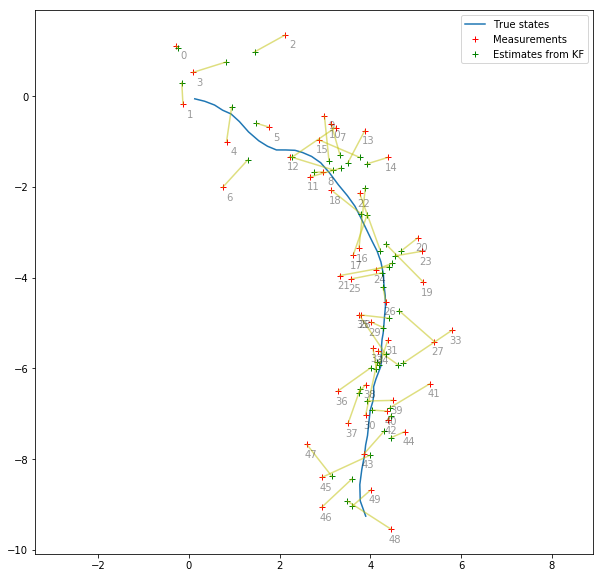

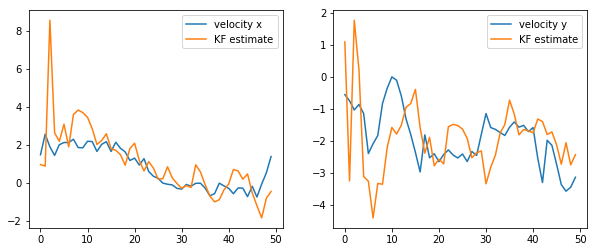

In [14]:
common.plot_results(traj, x_log)